In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from skimage.io import imread, imshow
from skimage import transform
from skimage.filters import prewitt_h,prewitt_v
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer


In [ ]:
import os
path = r"/content/drive/MyDrive/HARP_DATASET/1_day_image/square_images_size50"
os.chdir(path)

spectrograms = []

with os.scandir(path) as files:
    for file in files:
        if file.name.endswith('.png'):
            spectrograms.append(file.name)

print(len(spectrograms))

3990


In [ ]:
width_and_height = 50

In [ ]:
import pandas as pd 

In [ ]:
data = {}

average_variance = {}
average_variance["gray"] = []
average_variance["edge"] = []
average_variance["means"] = []

In [ ]:
def extract_gray_features(image, use_pca=True):
    features_gray = np.reshape(image, (width_and_height,width_and_height))

    if use_pca == False:
      return features_gray.reshape(features_gray.shape[0] * features_gray.shape[1])

    pca = PCA(n_components=10, random_state=22)
    pca.fit(features_gray)
    X_reduced_features_gray = pca.transform(features_gray)
    average_variance["gray"].append(sum(pca.explained_variance_ratio_))

    # X_reduced_features_gray = X_reduced_features_gray.reshape(-1,2240)
    X_reduced_features_gray = X_reduced_features_gray.reshape(X_reduced_features_gray.shape[0] * X_reduced_features_gray.shape[1])

    return X_reduced_features_gray


In [ ]:
def extract_edges_features(image, use_pca=True):

  edges_prewitt_horizontal = prewitt_h(image)
  edges_prewitt_vertical = prewitt_v(image)

  features_edge = np.concatenate([np.reshape(edges_prewitt_vertical, (width_and_height,width_and_height)),
                     np.reshape(edges_prewitt_horizontal, (width_and_height,width_and_height))])
  
  if use_pca == False:
    return features_edge.reshape(features_edge.shape[0] * features_edge.shape[1])

  pca = PCA(n_components=10, random_state=22)
  pca.fit(features_edge)
  X_reduced_features_edge = pca.transform(features_edge)
  average_variance["edge"].append(sum(pca.explained_variance_ratio_))

  X_reduced_features_edge = X_reduced_features_edge.reshape(X_reduced_features_edge.shape[0] * X_reduced_features_edge.shape[1])

  return X_reduced_features_edge


In [ ]:
def extract_means_pixel_channel_features(image, use_pca=True):
    feature_matrix = np.zeros((width_and_height,width_and_height)) 
    for i in range(0,image.shape[0]):
      for j in range(0,image.shape[1]):
        feature_matrix[i][j] = ((int(image[i,j,0]) + int(image[i,j,1]) + int(image[i,j,2]))/3)

    features_mean_pixel = np.reshape(feature_matrix, (width_and_height,width_and_height))

    if use_pca == False:
      return features_mean_pixel.reshape(features_mean_pixel.shape[0] * features_mean_pixel.shape[1])

    pca = PCA(n_components=10, random_state=22)
    pca.fit(features_mean_pixel)
    X_reduced_mean_pixel = pca.transform(features_mean_pixel)
    average_variance["means"].append(sum(pca.explained_variance_ratio_))

    X_reduced_mean_pixel = X_reduced_mean_pixel.reshape(X_reduced_mean_pixel.shape[0] * X_reduced_mean_pixel.shape[1])

    return X_reduced_mean_pixel


In [ ]:
def standardize_data(features_to_standardize):

  absolute_maximum = np.absolute(features_to_standardize.max())
  absolute_min = np.absolute(features_to_standardize.min())

  max_value = absolute_min if absolute_min > absolute_maximum else absolute_maximum

  features_to_standardize = features_to_standardize/max_value

  return features_to_standardize

In [ ]:
def extract_all_features(spectrograms: list):
  for spectrogram in spectrograms:
    image = imread(spectrogram, as_gray=True)

    gray_features = extract_gray_features(image, use_pca=True)
    gray_features = standardize_data(gray_features)

    edge_features = extract_edges_features(image, use_pca=True)
    edge_features = standardize_data(edge_features)

    image = imread(spectrogram)

    means_value_features = extract_means_pixel_channel_features(image, use_pca=True)
    means_value_features = standardize_data(means_value_features)

    final_feature = np.concatenate([gray_features, edge_features, means_value_features ])

    data[spectrogram] = final_feature


In [ ]:
extract_all_features(spectrograms)

In [ ]:
print("Average variance for grayscale = " + str(sum(average_variance['gray'])/ len(average_variance['gray'])))
print("Average variance for edge = " + str(sum(average_variance['edge'])/ len(average_variance['edge'])))
print("Average variance for means = " + str(sum(average_variance['means'])/ len(average_variance['means'])))

Average variance for grayscale = 0.9181137741756769
Average variance for edge = 0.9082579537421966
Average variance for means = 0.9120028605112501


In [ ]:
print(data[spectrograms[0]])

[-0.98094074 -0.14738975  0.36483594 ...  0.23273708  0.25397334
 -0.16297013]


In [ ]:
data[spectrograms[0]].shape

(2000,)

In [ ]:
feat = np.array(list(data.values()))
feat.shape, feat

((3990, 2000), array([[-0.98094074, -0.14738975,  0.36483594, ...,  0.23273708,
          0.25397334, -0.16297013],
        [-0.46588042,  0.06163947,  0.18892398, ..., -0.09827103,
          0.1054038 , -0.03921897],
        [-0.12250132, -0.2507755 ,  0.69892756, ...,  0.08830376,
         -0.03588255,  0.06539289],
        ...,
        [ 0.92550898,  0.45942066,  0.10747971, ...,  0.19375046,
          0.20117541,  0.28997092],
        [ 1.        , -0.03357547,  0.19890181, ..., -0.19726198,
         -0.0293697 ,  0.0315261 ],
        [-0.49429467, -0.29769499,  0.25728326, ...,  0.06468782,
         -0.08336387,  0.05270188]]))

In [ ]:
# pca = PCA(n_components=50, random_state=22)
# pca.fit(feat)
# x = pca.transform(feat)
x = feat

In [ ]:
print("Average variance for total = " + str(sum(pca.explained_variance_ratio_)))

NameError: ignored

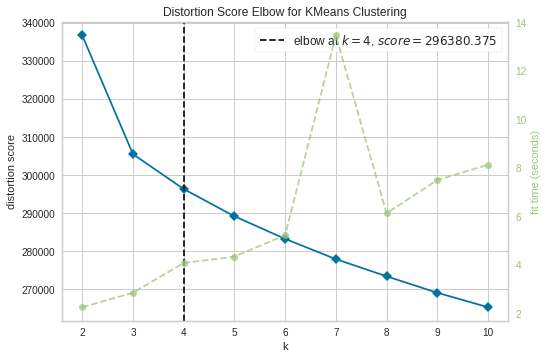

4

In [ ]:
# Generate synthetic dataset with 8 random clusters
model = KElbowVisualizer(KMeans(), k=10)

model.fit(x)

model.show()

model.elbow_value_


In [ ]:
# cluster feature vectors
kmeans = KMeans(n_clusters=model.elbow_value_, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=4, random_state=22)

In [ ]:
groups = {}
def extract_groups():
  for spectrogram_name, label in zip(spectrograms, kmeans.labels_):
    if label not in groups:
      groups[label] = []
    groups[label].append(spectrogram_name)


In [ ]:
from tensorflow.keras.utils import load_img

def view_cluster(cluster, n_pictures=30):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to n_pictures images to be shown at a time
    if len(files) > n_pictures:
        print(f"Clipping cluster size from {len(files)} to {n_pictures}")
        files = files[:(n_pictures-1)]
    # plot each image in the cluster
    print("Cluster " + str(cluster) + " ------------------------------------------------------------------------------------------------------------------------------------------------------------------- ")  
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [ ]:
print(kmeans.labels_[:500])
print(len(kmeans.labels_))

[3 0 2 1 0 1 0 3 3 1 0 3 2 0 0 0 1 3 3 3 2 1 0 0 0 0 0 0 2 0 1 0 3 3 2 3 0
 2 0 1 3 0 0 0 3 3 0 3 3 1 3 3 3 1 0 3 1 3 3 3 0 1 1 0 0 3 3 3 2 0 3 0 0 2
 3 3 3 0 3 1 0 1 3 1 3 3 1 0 0 2 0 0 1 1 3 1 3 1 2 3 0 0 0 0 0 0 0 0 1 0 0
 3 3 1 3 0 0 0 0 0 0 0 0 2 3 3 3 0 3 0 0 0 0 0 3 0 2 3 3 3 0 1 0 0 0 3 3 0
 0 3 0 0 3 0 0 0 3 0 0 3 3 3 3 3 3 3 3 0 0 0 3 3 0 3 3 3 3 2 1 1 3 1 3 3 0
 3 3 3 3 3 3 1 3 3 3 3 0 3 3 1 1 1 3 3 0 3 0 0 0 0 0 3 0 0 3 3 0 3 0 0 1 3
 3 1 0 3 3 0 3 3 3 3 3 0 3 0 0 3 0 0 1 1 0 3 0 3 0 0 1 0 1 0 0 2 1 3 2 0 3
 3 3 3 0 3 1 2 2 1 0 1 3 0 3 3 0 0 0 0 0 3 3 1 1 0 2 3 2 1 1 0 3 1 0 0 1 0
 0 0 3 1 1 0 1 1 3 0 0 3 0 2 1 0 2 0 0 0 2 3 3 3 0 0 3 3 3 2 1 3 1 0 3 3 3
 1 1 0 2 3 0 0 1 1 0 3 0 3 1 3 1 1 0 2 0 3 0 1 1 3 3 1 0 3 3 3 2 3 3 1 1 0
 0 3 1 1 1 1 3 3 2 0 1 0 0 0 3 3 3 0 1 1 0 3 3 1 3 0 1 0 2 3 3 3 0 3 0 2 0
 0 3 1 1 3 0 2 3 3 2 3 1 3 0 2 3 1 3 0 3 1 3 1 0 2 3 3 2 0 0 1 1 1 1 1 2 0
 3 0 3 0 0 3 1 3 3 1 0 0 0 0 0 3 0 3 0 0 0 0 0 3 0 3 0 1 0 0 0 1 3 0 1 0 0
 3 2 1 3 3 0 0 0 0 0 3 0 

In [ ]:
extract_groups()

In [ ]:
view_cluster(0,100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_cluster(1,100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_cluster(2,100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_cluster(3,100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view_cluster(4,100)

KeyError: ignored

<Figure size 1800x1800 with 0 Axes>